In [1]:
# import packages
import seaborn as sns
import numpy as np
from scipy.io import loadmat
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import string
import matplotlib.transforms as mtransforms

# define paths
results_dir = "/space/syn50/1/data/ABCD/d9smith/behav_genet_2023/results_20230227/";
outpath = "/home/d9smith/projects/behav_genet_2023/plots/";

In [2]:
params = loadmat(results_dir + 'model_parameters.mat')

In [3]:
fstem_imaging = [item.astype(str).tolist()[0] for item in params['fstem_imaging'][0]]
titles = [item.astype(str).tolist()[0] for item in params['titles'][0]]

fstem_imaging = list(filter(None, fstem_imaging))
titles = list(filter(None, titles))

In [4]:
# make RandomEffects an array of arrays
RandomEffects = [[char.astype(str).tolist() for char in item] for item in \
                 [item.ravel().tolist() for item in params['RandomEffects'][0]]]

RandomEffects = list(filter(None, RandomEffects))
# RandomEffects

In [5]:
models = pd.DataFrame(fstem_imaging, columns =['shortname'])
models['title'] = titles
models['RandomEffects'] = RandomEffects

models

,shortname,title,RandomEffects
0,model1,"FEMA ACE Model, twin sample, baseline, kinship...","[[A], [F], [E]]"
1,model2,"ACE Model, twin sample, baseline, SNP-derived GRM","[[A], [F], [E]]"
2,model3,"ACE Model, full sample, baseline, SNP-derived GRM","[[A], [F], [E]]"
3,model4,"ACTE Model, full sample, baseline, SNP-derived...","[[A], [F], [T], [E]]"
4,model5,"ACE Model, full sample, baseline and Y2, SNP-d...","[[A], [F], [E]]"
5,model6,"ACSE Model, full sample, baseline and Y2, SNP-...","[[A], [F], [S], [E]]"
6,s1_assigngrm_m3,"ACE Model, full sample, baseline, kinship-deri...","[[A], [F], [E]]"
7,s1_assigngrm_m4,"ACTE Model, full sample, baseline, kinship-der...","[[A], [F], [T], [E]]"
8,s1_assigngrm_m5,"ACSE Model, full sample, baseline and Y2, kins...","[[A], [F], [S], [E]]"
9,s2_allcovs_m1,"ACE Model, twin sample, baseline, kinship-deri...","[[A], [F], [E]]"


In [6]:
models['y2_only'] = [False, False, False, False, True, True, False, False, True, False, \
                     False, False, True, True, True]

models

,shortname,title,RandomEffects,y2_only
0,model1,"FEMA ACE Model, twin sample, baseline, kinship...","[[A], [F], [E]]",False
1,model2,"ACE Model, twin sample, baseline, SNP-derived GRM","[[A], [F], [E]]",False
2,model3,"ACE Model, full sample, baseline, SNP-derived GRM","[[A], [F], [E]]",False
3,model4,"ACTE Model, full sample, baseline, SNP-derived...","[[A], [F], [T], [E]]",False
4,model5,"ACE Model, full sample, baseline and Y2, SNP-d...","[[A], [F], [E]]",True
5,model6,"ACSE Model, full sample, baseline and Y2, SNP-...","[[A], [F], [S], [E]]",True
6,s1_assigngrm_m3,"ACE Model, full sample, baseline, kinship-deri...","[[A], [F], [E]]",False
7,s1_assigngrm_m4,"ACTE Model, full sample, baseline, kinship-der...","[[A], [F], [T], [E]]",False
8,s1_assigngrm_m5,"ACSE Model, full sample, baseline and Y2, kins...","[[A], [F], [S], [E]]",True
9,s2_allcovs_m1,"ACE Model, twin sample, baseline, kinship-deri...","[[A], [F], [E]]",False


In [7]:
baseline_phenos = ["matrix", "littleman", "ravlt",  "pattern", "flanker",  "cardsort", "list", "picture", \
                   "picvocab", "reading", "cryst", "fluidcomp", "totalcomp", "height"]

y2_phenos = ["littleman", "ravlt", "pattern", "flanker", "picture", "picvocab", "reading", "cryst", "height"]

In [8]:
# set up paths to results files
results_file = [(results_dir + 'FEMA_wrapper_output_external_' + item + '.json') for item in fstem_imaging]
sig2mat_file = [(results_dir + 'FEMA_wrapper_output_external_' + item + '_sig2mat.json') for item in fstem_imaging]

In [9]:
# define a function for loading results
def load_model(results_file, sig2mat_file, RandomEffects, idx, y2_only = False):
    """
    Loads model and sig2mat from specified results files.
    
    arguments:
    results_file   :  list of .json files where FEMA results are stored -- saved from bg_fema_wrapper.m
    sig2mat_file   :  list of .json files where sig2mat is stored -- saved from bg_fema_wrapper.m
    RandomEffects  :  list of random effects specified for each model
    idx            :  index variable (index is same for each list)
    y2_only        :  indicates whether phenotypes are limited to those collected at year 2
    
    """
    model_file = results_file[idx]
    sig2mat_file = sig2mat_file[idx]
    model = pd.read_json(model_file)
    with open(sig2mat_file) as f:
        sig2mat = json.load(f)
    sig2mat = [pd.DataFrame(s, columns = ['est', 'll', 'ul']) for s in sig2mat]
    for item in sig2mat:
        item['errormin'] = item['est'] - item['ll']
        item['errormax'] = item['ul'] - item['est']
        if y2_only == True:
            item['pheno'] = y2_phenos
        else: 
            item['pheno'] = baseline_phenos      
            
    for i in range(0,len(RandomEffects[idx])):
        sig2mat[i]['param'] = RandomEffects[idx][i][0]
        
    sig2mat = pd.concat(sig2mat)
    
    return model, sig2mat

In [10]:
model = []
sig2mat = []

for i in range(len(models)):
    new_model, new_sig2mat = load_model(results_file, sig2mat_file, RandomEffects, i, models['y2_only'][i])
    model.append(new_model)
    sig2mat.append(new_sig2mat)

In [11]:
# add mx to list of parameters
models.loc[len(models.index)] = ["openmx", "OpenMx ACE Model, twins only at baseline, GRM assumed", \
                                 [['A'], ['F'], ['E']], False] 

In [12]:
# Load OpenMx parameters
mxa_file = results_dir + "openmx_A.csv"
mxc_file = results_dir + "openmx_C.csv"
mxe_file = results_dir + "openmx_E.csv"
mxloglik_file = results_dir + "openmx_loglik.csv"

def load_mx(filename, phenonames, param):
    df = pd.read_csv(filename)
    df.columns = ['pheno', 'est', 'll', 'ul']
    df['errormin'] = df['est'] - df['ll']
    df['errormax'] = df['ul'] - df['est']
    df['pheno'] = phenonames
    df['param'] = param
    return df

mxa = load_mx(mxa_file, baseline_phenos, 'A')
mxc = load_mx(mxc_file, baseline_phenos, 'F')
mxe = load_mx(mxe_file, baseline_phenos, 'E')
mxloglik = pd.read_csv(mxloglik_file)

openmx = pd.concat([mxa, mxc, mxe])
sig2mat.append(openmx)

model.append(mxloglik.rename(columns={"openmx_loglik": "logLikvec"}))

In [13]:
models['name'] = ['Model ' + str(i+1) for i in range(len(models))]
# models[models['shortname'] == 'openmx']['name'] = 'Model 1'

models.at[(models.index[models['shortname'] == 'openmx'].tolist()[0]),'name']='Model 1'



In [14]:
models

,shortname,title,RandomEffects,y2_only,name
0,model1,"FEMA ACE Model, twin sample, baseline, kinship...","[[A], [F], [E]]",False,Model 1
1,model2,"ACE Model, twin sample, baseline, SNP-derived GRM","[[A], [F], [E]]",False,Model 2
2,model3,"ACE Model, full sample, baseline, SNP-derived GRM","[[A], [F], [E]]",False,Model 3
3,model4,"ACTE Model, full sample, baseline, SNP-derived...","[[A], [F], [T], [E]]",False,Model 4
4,model5,"ACE Model, full sample, baseline and Y2, SNP-d...","[[A], [F], [E]]",True,Model 5
5,model6,"ACSE Model, full sample, baseline and Y2, SNP-...","[[A], [F], [S], [E]]",True,Model 6
6,s1_assigngrm_m3,"ACE Model, full sample, baseline, kinship-deri...","[[A], [F], [E]]",False,Model 7
7,s1_assigngrm_m4,"ACTE Model, full sample, baseline, kinship-der...","[[A], [F], [T], [E]]",False,Model 8
8,s1_assigngrm_m5,"ACSE Model, full sample, baseline and Y2, kins...","[[A], [F], [S], [E]]",True,Model 9
9,s2_allcovs_m1,"ACE Model, twin sample, baseline, kinship-deri...","[[A], [F], [E]]",False,Model 10


In [15]:
def my_colors(RandomEffects):
    """
    Takes a list of random effects and returns colors in the correct order.

    """
    
    labels = np.array(RandomEffects)
    dict = {'A':'#1f77b4','C':'#ff7f0e','F':'#ff7f0e','T':'#d62728','S':'#9467bd','E':'#2ca02c'}
    colors = [dict[lbl] for lbl in RandomEffects]
    return colors

print(my_colors('T')[0])


#d62728


In [16]:
# function to compare two models
def compare_models(name1, name2, sig2mat, models, ax = None, lbl = None):
    """
    Visualize FEMA random effects estimates with confidence intervals.
    
    arguments:
    model1          :    string with title of model to plot on x axis
    model2          :    string with title of model to plot on y axis
    sig2mat         :    list of sig2mat matrices with random effects estimates
    models          :    dataframe of model parameters
    lbl             :    optional argument to supply minimum difference to label (if number)
    
    """
    i = models.index[models['shortname'] == name1].tolist()[0]
    j = models.index[models['shortname'] == name2].tolist()[0]
    
    model1 = sig2mat[i]
    model2 = sig2mat[j]
    
    title1 = models['title'][i]
    title2 = models['title'][j]
    
    modnum1 = models['name'][i]
    modnum2 = models['name'][j]

    tmp = model1.merge(model2, on = ['pheno', 'param'], suffixes = ['_model1', '_model2'])
    
    tmp['param'] = tmp['param'].replace('F','C')
#     print(tmp[tmp['param']=='A'])
    ax = ax or plt.gca()

    groups = tmp.groupby('param')
    for name, group in groups:
        ax.plot(group.est_model1, group.est_model2, marker='o', linestyle='', 
                markersize=5, label=name, color = my_colors(name)[0])
        
       
    #get handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    #specify order of items in legend    
    if len(labels) == 3:
        order = [0,1,2]
    elif len(labels) == 4:
        order = [0,1,3,2]
    elif len(labels) == 5:
        order = [0,1,4,3,2]

    #add legend to plot
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
    
    # creating error
    x_errormin = tmp['errormin_model1']
    x_errormax = tmp['errormax_model1']

    y_errormin = tmp['errormin_model2']
    y_errormax = tmp['errormax_model2']

    x_error = [x_errormin, x_errormax]
    y_error = [y_errormin, y_errormax]

    ax.errorbar(tmp['est_model1'], tmp['est_model2'],
                 yerr=y_error,
                 xerr=x_error,
                 fmt='none',
                ecolor = 'black',
                elinewidth = 0.3)  

    ax.set_title(modnum1 + ' vs ' + modnum2)
    # Set x-axis label
    ax.set_xlabel(modnum1 + ':\n' + models['title'][i])
    # Set y-axis label
    ax.set_ylabel(modnum2 + ':\n' + models['title'][j])
    
    # add line at model 1 = model 2
    ax.plot([0, 1], [0, 1], 'k-')
    
    # add labels
    tmp['diff'] = tmp['est_model1'] - tmp['est_model2']

    if(lbl):
        
        if type(lbl) == float:

            labels = tmp[abs(tmp['diff']) > lbl]
            label_x = labels['est_model1'].tolist()
            label_y = labels['est_model2'].tolist()
            labels_txt = labels['pheno'].tolist()
            x_offset = (5 * labels['diff']/abs(labels['diff'])).tolist()
            align = ['left' if item > 0 else 'right' for item in labels['diff'].tolist()]



        elif type(lbl) == list:
            label_x, label_y, labels_txt, x_offset, align = [[],[],[],[],[]]
            for pheno, param in lbl:
                labels_txt.append(pheno)
                label_x.append(tmp[(tmp['param'] == param) & (tmp['pheno'] == pheno)]['est_model1'].squeeze())
                label_y.append(tmp[(tmp['param'] == param) & (tmp['pheno'] == pheno)]['est_model2'].squeeze())
                diff = tmp[(tmp['param'] == param) & (tmp['pheno'] == pheno)]['diff'].squeeze()
                
                x_offset.append(5 * diff/abs(diff))
                align.append('left' if diff > 0 else 'right')
                
        for i, txt in enumerate(labels_txt):
            ax.annotate(txt, (label_x[i], label_y[i]), textcoords="offset points", # how to position the text
                     xytext=(x_offset[i],5), # distance from text to points (x,y)
                     ha=align[i]) # horizontal alignment can be left, right or center)
            
    sns.despine()

#     plt.show()
    return ax

# for debugging
# compare_models("model1", "openmx", sig2mat, models)

In [17]:
# create function to write stacked bar graph for each model
def stacked_bar(model_name, sig2mat_list, models, ax = None, label=0.04):
    """
    Plots a stacked bar chart of random effects estimates for a given model.
    
    Args:
      model_name : string that corresponds to name of model
      sig2mat_list : list of sig2mat matrices of random effects
      models : dataframe of model parameters
      label : threshold for labeling bars
      
    """
    i = models.index[models['shortname'] == model_name].tolist()[0]
    
    df = pd.pivot_table(sig2mat_list[i][['est', 'pheno', 'param']], values='est', index=['pheno'], columns=['param'], sort=False)
    
    fields = [j[0] for j in models['RandomEffects'][i]]
    labels = ['C' if item == 'F' else item for item in fields]
    print()
        #specify order of items in legend    
    if len(labels) == 3:
        order = [0,1,2]
    elif len(labels) == 4:
        order = [0,1,3,2]
    else:
        order = [0,1,3,4,2]
    
    ax = ax or plt.gca()

    # figure and axis
#     fig, ax = plt.subplots(1, figsize=(9, 7.5))

    # plot bars
    left = len(df) * [0]
    for idx, name in enumerate(fields):
        ax.barh(df.index, df[name], left = left, color = my_colors(name)[0])
        left = left + df[name]
    
    # title, legend, labels
    ax.set_title(models['name'][i] + ':\n' + models['title'][i] + '\n', loc='left')
    ax.set_xlabel('Proportion of Variance')

    #add legend to plot
    ax.legend(labels, loc = 'lower left', bbox_to_anchor=([-0.02, 0.98]), ncol=5, frameon=False) 
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
    # add data labels
    for c in ax.containers:
        labels = ["{:.2f}".format(v.get_width()) if v.get_width() >= label else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center')  
        
    sns.set_context("paper")
       
#     plt.show()
    return ax

# for debugging
# stacked_bar("s3_notwins", sig2mat, models, label = 0.05)


In [18]:
print(baseline_phenos)
print(y2_phenos)
# print(list(baseline_phenos[y2_phenos]))

y2_idx = [baseline_phenos.index(i) for i in y2_phenos]
print([baseline_phenos[i] for i in y2_idx])
print(y2_idx)

['matrix', 'littleman', 'ravlt', 'pattern', 'flanker', 'cardsort', 'list', 'picture', 'picvocab', 'reading', 'cryst', 'fluidcomp', 'totalcomp', 'height']
['littleman', 'ravlt', 'pattern', 'flanker', 'picture', 'picvocab', 'reading', 'cryst', 'height']
['littleman', 'ravlt', 'pattern', 'flanker', 'picture', 'picvocab', 'reading', 'cryst', 'height']
[1, 2, 3, 4, 7, 8, 9, 10, 13]


In [19]:
print(list(range(0,len(y2_phenos))))

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [20]:
# function to plot difference in AIC between two models
def plot_aic(name1, name2, model, models, phenonames, ax = None, label = None, sig2tvec = False, \
             baseline_phenos = None, debug=False):
#     """
#     Visualize difference in AIC (computed as -2(delta LL) + 2(delta k).
#     If model 1 performs better than model 2, delta_aic < 0
#     If model 2 performs better than model 1, delta_aic > 0
    
#     arguments:
#     name1          :    string with title of model to plot on x axis
#     name2          :    string with title of model to plot on y axis
#     model          :    dataframe of model results
#     models         :    dataframe of model parameters
#     phenonames     :    list of phenotypes (usually baseline_phenos or y2_phenos)
#     sig2tvec       :    optional - will cause plot to show change in sig2tvec instead
    
#     """

    i = models.index[models['shortname'] == name1].tolist()[0]
    j = models.index[models['shortname'] == name2].tolist()[0]

    model1 = model[i]
    model2 = model[j]

    # since all models are pre-residualized, k is equal to the number of random effects
    k = [len(row) for row in models['RandomEffects']]

    delta_aic = -2 * (model1['logLikvec']-model2['logLikvec']) + 2 * (k[i]-k[j])

    ax = ax or plt.gca()

    if (sig2tvec):
        # if one model is y2 phenos only and the other model is baseline only, need to select correct phenotypes to use.
        if len(model1['sig2tvec']) < len(model2['sig2tvec']):
            tmp = [baseline_phenos.index(i) for i in y2_phenos]
            model2 = model2.iloc[tmp].set_axis(list(range(0,len(y2_phenos))), axis='index')
            
        if len(model1['sig2tvec']) > len(model2['sig2tvec']):
            tmp = [baseline_phenos.index(i) for i in y2_phenos]
            model1 = model1.iloc[tmp].set_axis(list(range(0,len(y2_phenos))), axis='index')
            
        delta_sig2tvec = (model1['sig2tvec'] - model2['sig2tvec']) / model2['sig2tvec']
    
        if debug==True:
            print(delta_sig2tvec)

            print(phenonames)
        ax.barh(phenonames, delta_sig2tvec, color = "#c0d6e4")
        ax.set_xlabel("Percent change in residual");
        
        if isinstance(label,int):
            plt.axvline(x=label, color = 'k', ls=':')
        elif isinstance(label,list):
            for lbl in label:
                plt.axvline(x=lbl, color = 'k', ls=':')
        
    else: 
        if debug==True:
            print(delta_aic)
        ax.barh(phenonames, delta_aic, color = "#849DAB")
        ax.set_xlabel("Delta AIC\n(negative values favor " + models['name'][i] + ")");
        
        if isinstance(label,int):
            plt.axvline(x=label, color = 'k', ls=':')
        elif isinstance(label,list):
            for lbl in label:
                plt.axvline(x=lbl, color = 'k', ls=':')
    
    plt.axvline(x=0, color = 'k', ls = '-', lw = 0.5)
            
    sns.set_context("paper")
    sns.despine()
    
    return ax

# plot_aic("model5", "model3", model, models, y2_phenos, sig2tvec = True, baseline_phenos = baseline_phenos, debug = False)
# plt.xscale("log")

In [21]:
# function to add labels to subplots (A, B, C, etc)
def label_subplots(axs):
#     """
#     Takes a list of subplots, for example, [ax0, ax1, ax2].
#     Adds labels to each subplot.
    
#     arguments:
#     axs          :    list of axes    

#     """

    for n, ax in enumerate(axs):
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, string.ascii_uppercase[n], transform=ax.transAxes + trans,
                fontsize='large', verticalalignment='bottom', weight='bold')
#                 bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))



In [22]:
# set dimensions for figures
figwidth=16
figheight=7.2
wspace=0.4
hspace=0.25

# Figure 1. ACE Model in FEMA versus OpenMx

For cryst, pattern, and reading, the OpenMx estimates differ from the FEMA estimates. I suspect this is related to the error message I got in OpenMx for these: "In model 'oneACEc' Optimizer returned a non-zero status code 5. The Hessian at the solution does not appear to be convex. See ?mxCheckIdentification for possible diagnosis (Mx status RED)."

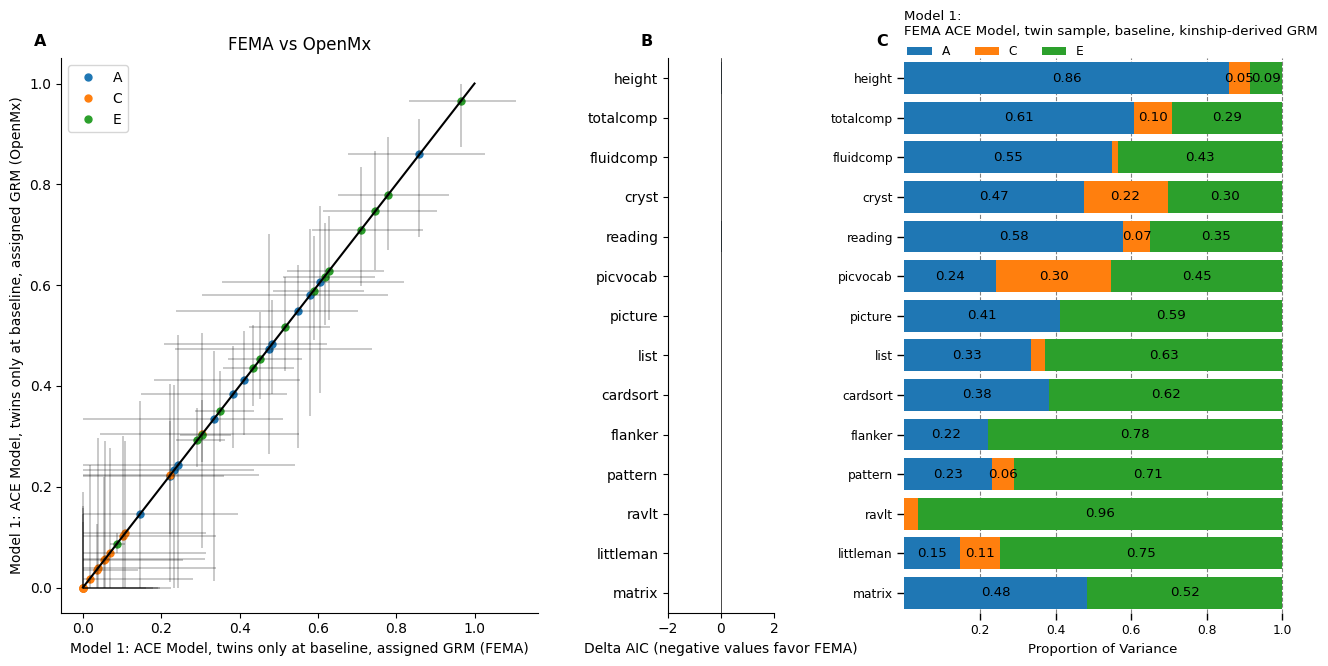

In [23]:
# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model1", "openmx", sig2mat, models, ax=ax0, lbl = 0.05)
ax0.set_title("FEMA vs OpenMx")
ax0.set_xlabel("Model 1: ACE Model, twins only at baseline, assigned GRM (FEMA)")
ax0.set_ylabel("Model 1: ACE Model, twins only at baseline, assigned GRM (OpenMx)")

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model1", "openmx", model, models, baseline_phenos, ax=ax1)
ax1.set_xlabel("Delta AIC (negative values favor FEMA)")
ax1.set_xlim(-2,2)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("model1", sig2mat, models, ax=ax2)

label_subplots([ax0,ax1,ax2])
plt.savefig(outpath + 'fig1.tiff', format='tiff', dpi = 300)

# 2. Figure 2. ACE Model using assigned versus measured GRM

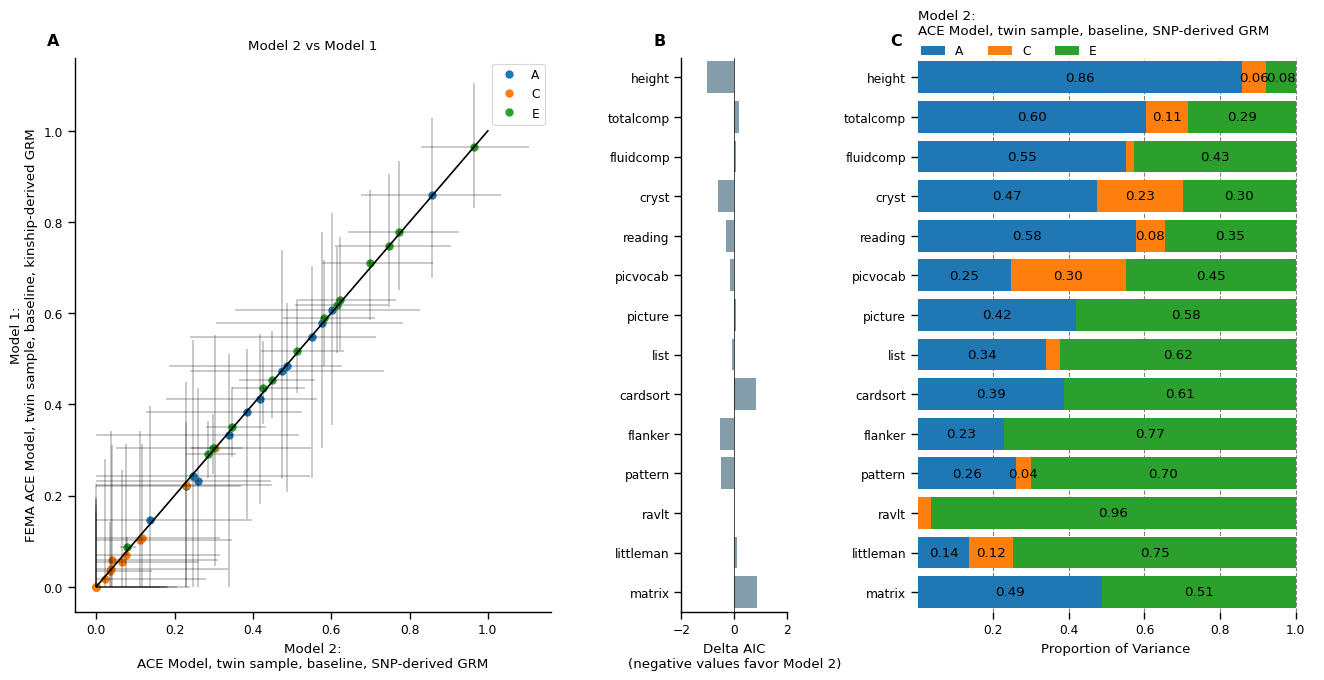

In [24]:
# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model2", "model1", sig2mat, models, ax=ax0)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model2", "model1", model, models, baseline_phenos, ax=ax1)
ax1.set_xlim(-2,2)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("model2", sig2mat, models, ax=ax2)

label_subplots([ax0,ax1,ax2])
plt.savefig(outpath + 'fig2.tiff', format='tiff', dpi = 300)

# Figure 3. ACE Model using full baseline sample compared to twin sub-sample

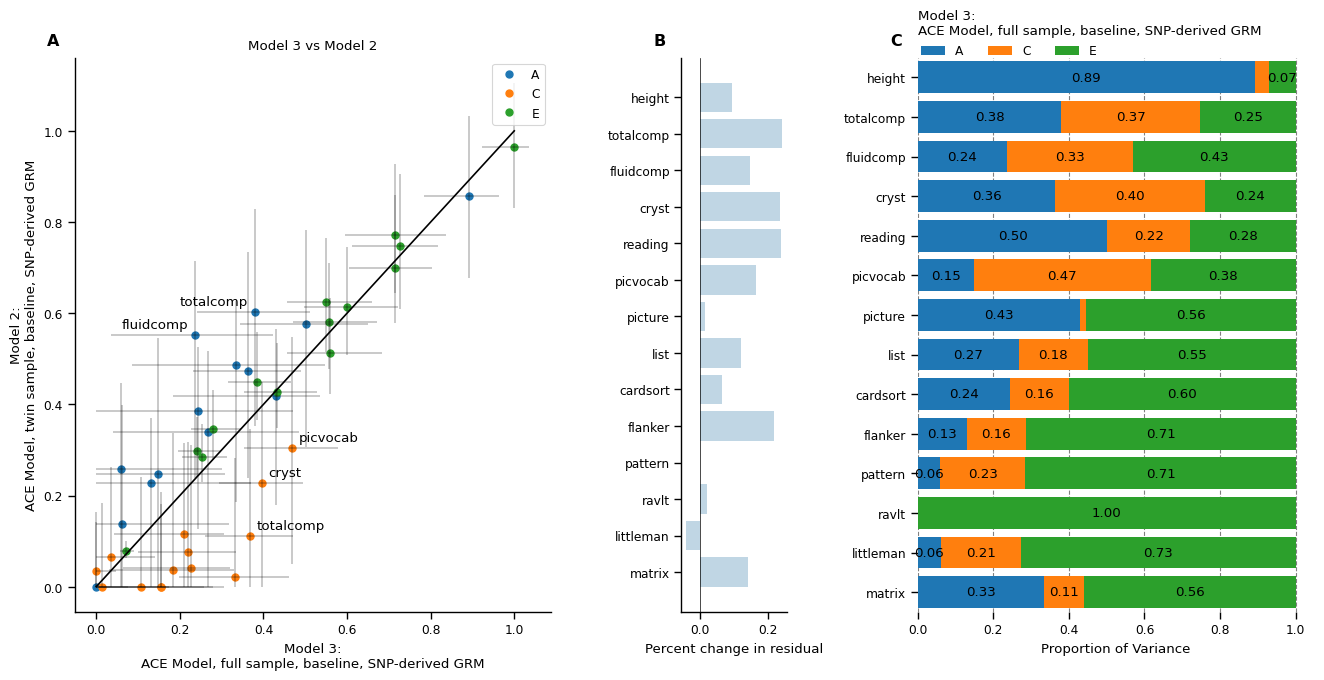

In [25]:
# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model3", "model2", sig2mat, models, ax=ax0, lbl = [("totalcomp", "A"), ("fluidcomp", "A"),
                                                           ("totalcomp", "C"), ("picvocab", "C"), ("cryst", "C")])

# middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model3", "model2", model, models, baseline_phenos, sig2tvec = True, ax=ax1, debug=False)
# ax1.set_xlim(-0.1,0.1)

# Right axes
ax2=fig.add_subplot(gs[0, 2])
stacked_bar("model3", sig2mat, models, ax=ax2)

label_subplots([ax0,ax1,ax2])
plt.savefig(outpath + 'fig3.tiff', format='tiff', dpi = 300)

# Supplementary Figure 1. ACE Model versus ACTE model using full baseline sample

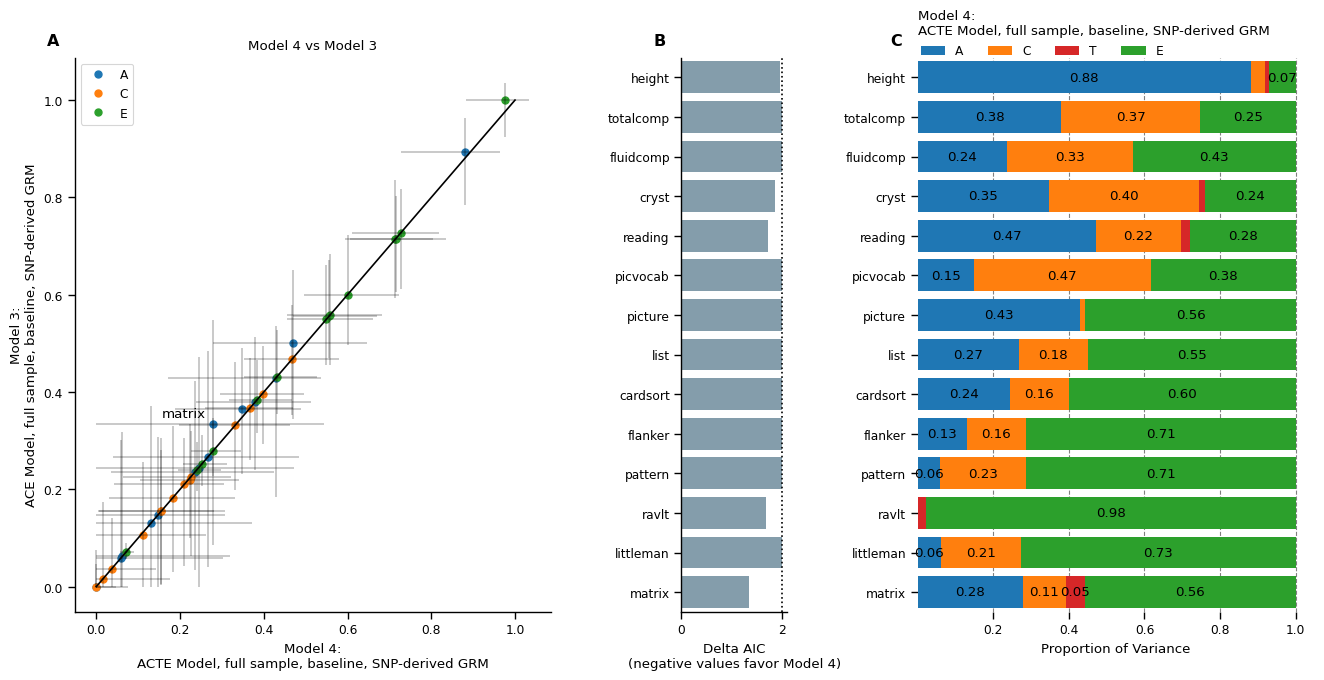

In [26]:
# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model4", "model3", sig2mat, models, ax=ax0, lbl = 0.05)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model4", "model3", model, models, baseline_phenos, label =2, ax=ax1, debug=False)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("model4", sig2mat, models, ax=ax2, label=.05)

label_subplots([ax0,ax1,ax2])
plt.savefig(outpath + 'suppfig1.tiff', format='tiff', dpi = 300)

# Figure 4. ACE and ACSE Model in baseline versus longitudinal sample


0     2.000007
1     1.721483
2   -25.604633
3   -11.326586
4     0.893331
5    -5.611738
6    -7.446833
7    -5.186196
8     2.000003
Name: logLikvec, dtype: float64



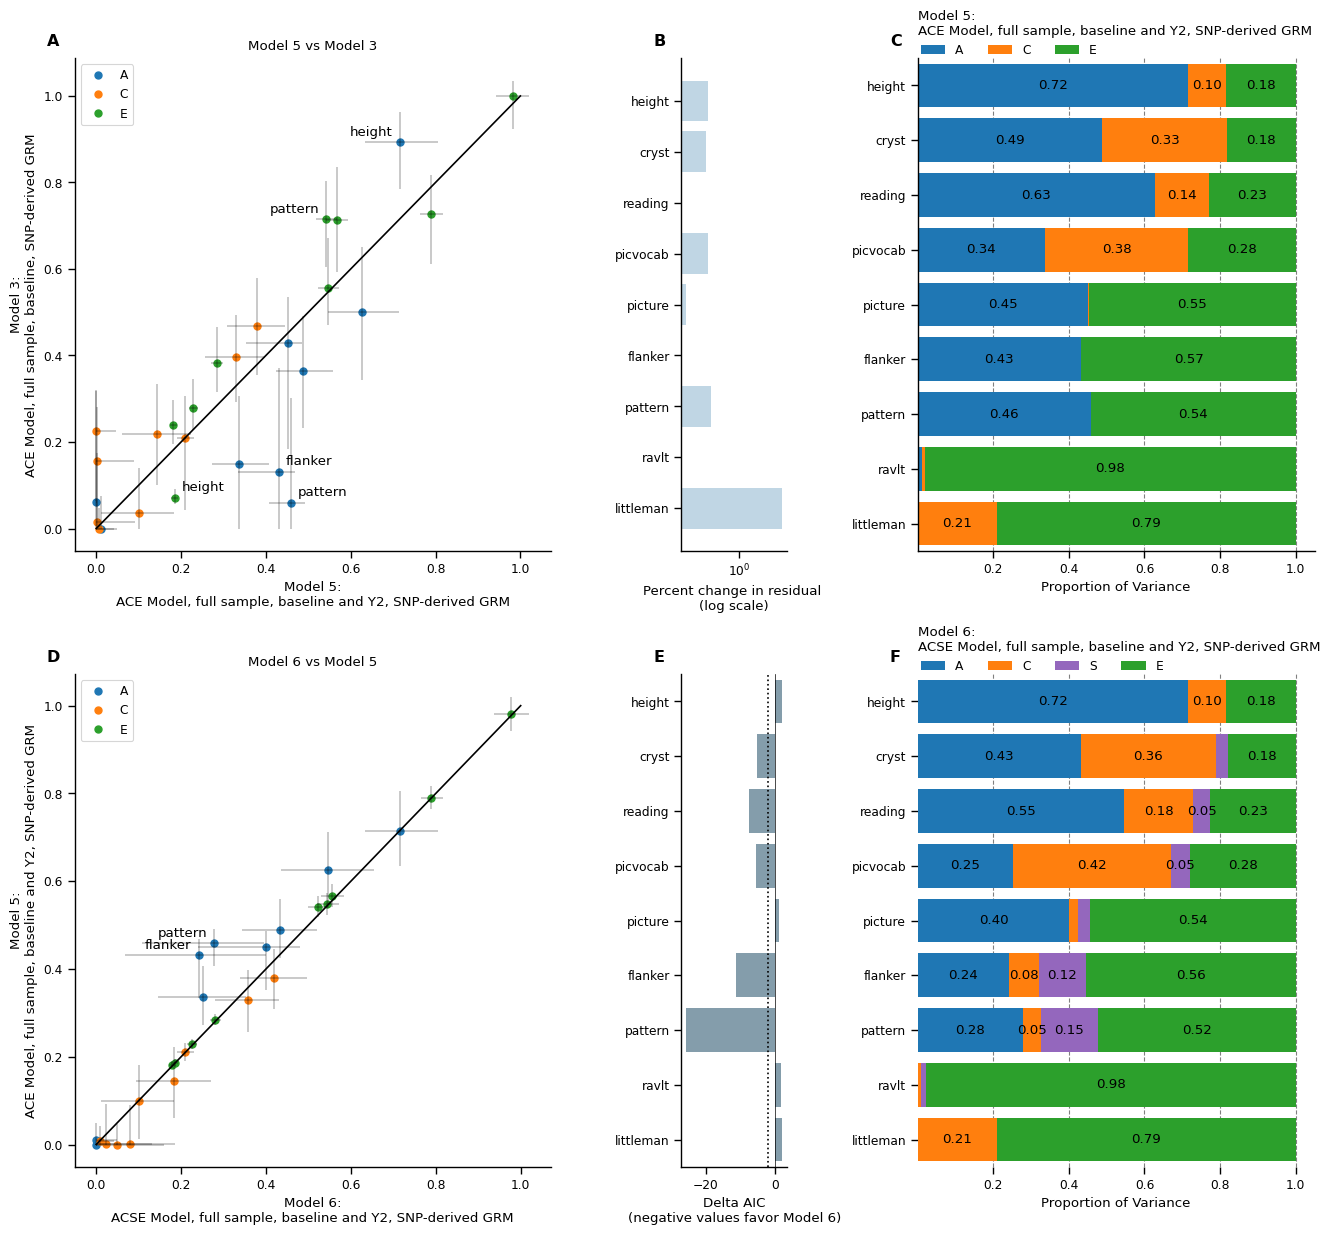

In [27]:
# compare_models("model5", "model4", sig2mat, models)

# stacked_bar("model5", sig2mat, models)

# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight*2))
gs = GridSpec(nrows=2, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

## Model 5 vs Model 3

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("model5", "model3", sig2mat, models, ax=ax0, lbl = [("height", "A"),("pattern", "A"), 
                                                                   ("flanker", "A"),("height","E"),
                                                                   ("pattern", "E")])
# compare_models("model5", "model4", sig2mat, models, ax=ax0, lbl = 0.1)

# middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model5", "model3", model, models, y2_phenos, sig2tvec = True, \
         baseline_phenos = baseline_phenos, debug=False)
plt.xscale("log")
ax1.set_xlabel("Percent change in residual \n(log scale)")

# ax1.set_xlim(-2,1)

# Right axes
ax2=fig.add_subplot(gs[0, 2])
stacked_bar("model5", sig2mat, models, ax=ax2)
# fig.tight_layout()

## Model 6 vs Model 5
# Left axes
ax3 = fig.add_subplot(gs[1, 0])
# compare_models("model6", "model5", sig2mat, models, ax=ax3, lbl = [("height", "A"),("pattern", "A"), 
#                                                                    ("pattern", "C"),("flanker", "A"),
#                                                                    ("picvocab", "E")])
compare_models("model6", "model5", sig2mat, models, ax=ax3, lbl = 0.1)


# Middle axes
ax4=fig.add_subplot(gs[1,1])
plot_aic("model6", "model5", model, models, y2_phenos, ax=ax4, label =-2, debug=True)

# Right axes
ax5=fig.add_subplot(gs[1, 2], sharey=ax4)
stacked_bar("model6", sig2mat, models, ax=ax5)
# fig.tight_layout()

label_subplots([ax0,ax1, ax2,ax3,ax4,ax5])
plt.savefig(outpath + 'fig4.tiff', format='tiff', dpi = 300)

# Figure 5. ACSE model using kinship- versus SNP-derived genetic relatedness

0    1.979060e-09
1   -1.215352e-03
2   -8.841604e+00
3    4.531554e-01
4    4.577113e-01
5   -8.747510e+00
6   -1.945336e+01
7   -1.759303e+01
8   -3.636249e+01
Name: logLikvec, dtype: float64



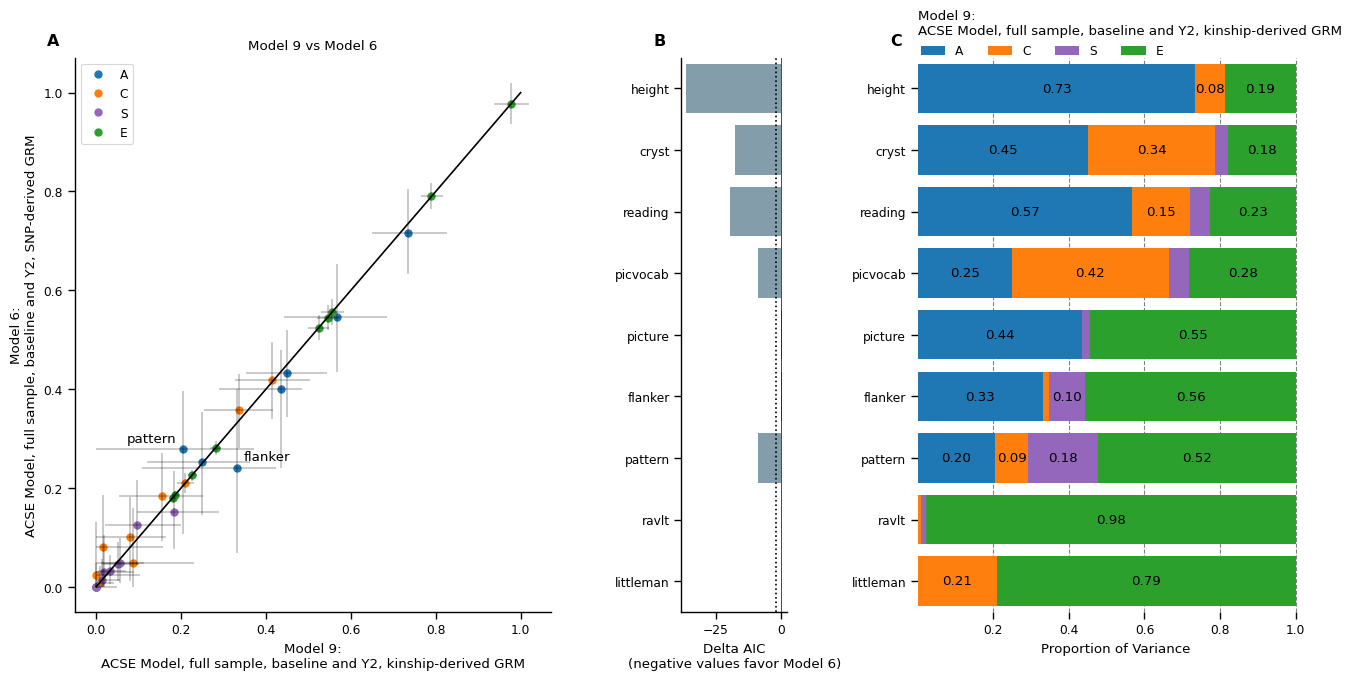

In [28]:
## MODEL 5 WITH ASSIGNED GRM

# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("s1_assigngrm_m5", "model6", sig2mat, models, ax=ax0, lbl = .07)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model6", "s1_assigngrm_m5", model, models, y2_phenos, label =-2, ax=ax1, debug=True)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s1_assigngrm_m5", sig2mat, models, ax=ax2, label = 0.06)

label_subplots([ax0,ax1,ax2])
plt.savefig(outpath + 'fig5.tiff', format='tiff', dpi = 300)

# Supplementary Figure 2. Model comparison using assigned versus measured genetic relatedness

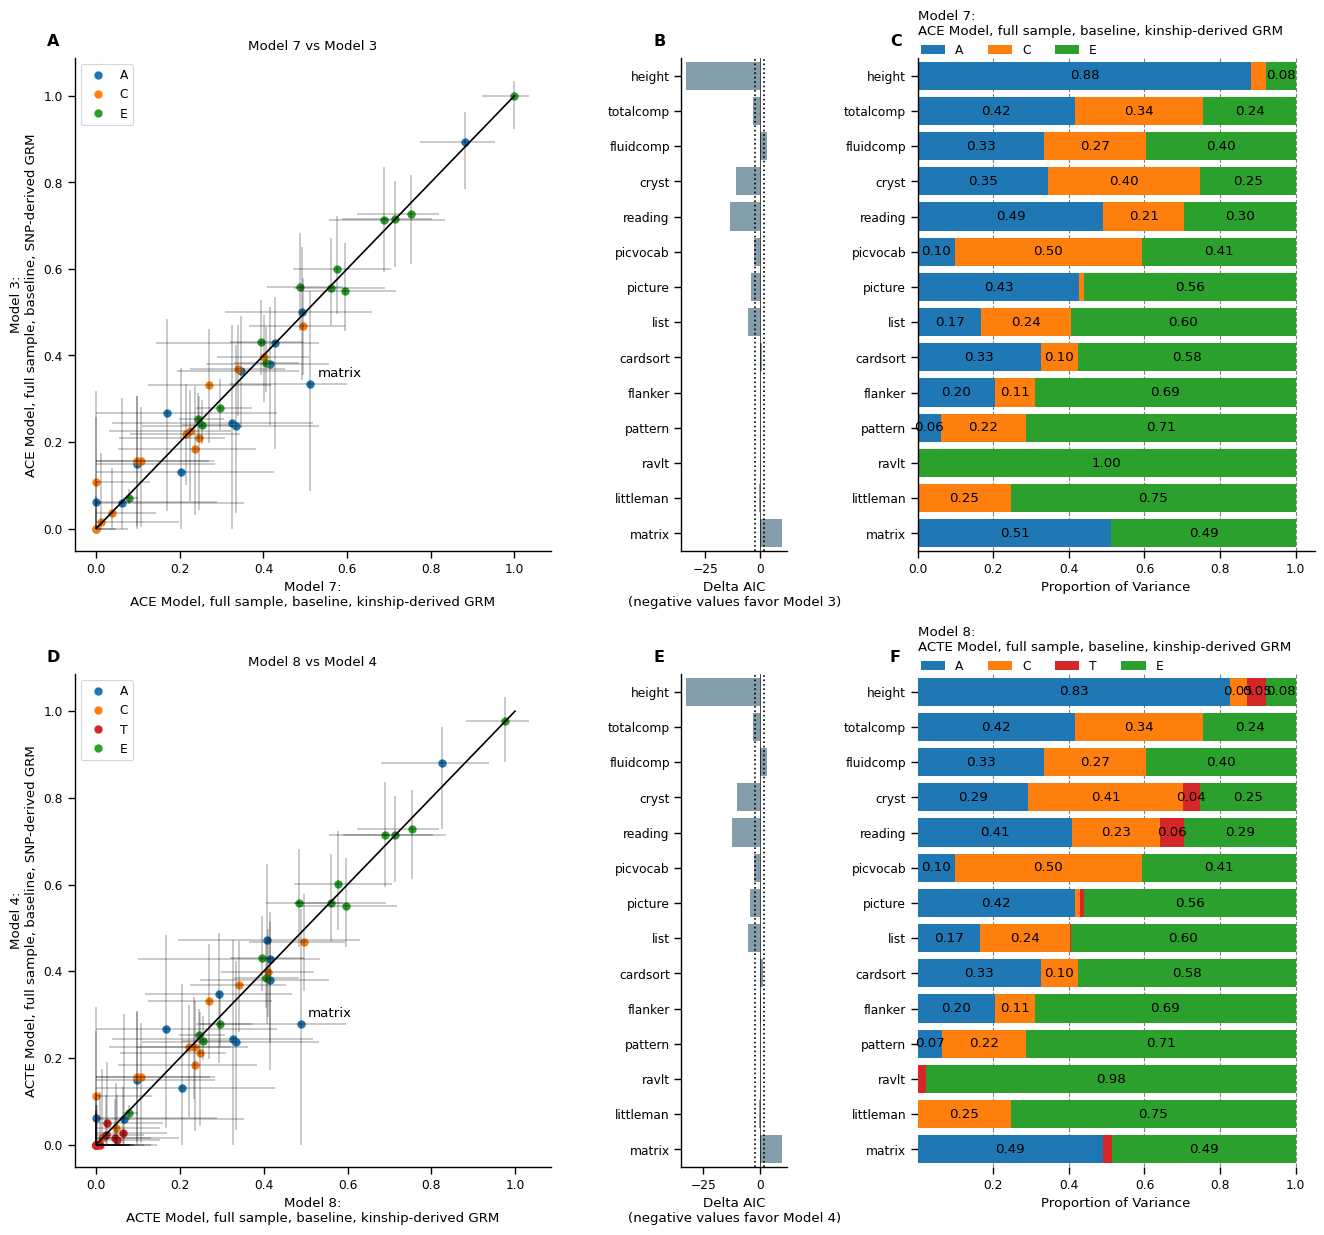

In [29]:
# compare_models("model5", "s1_assigngrm_m5", sig2mat, models)

# stacked_bar("s1_assigngrm_m5", sig2mat, models)

## MODEL 3 WITH ASSIGNED GRM

# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight*2))
gs = GridSpec(nrows=2, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("s1_assigngrm_m3", "model3", sig2mat, models, ax=ax0, lbl = .15)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("model3", "s1_assigngrm_m3", model, models, baseline_phenos, label =[-2,2], ax=ax1)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s1_assigngrm_m3", sig2mat, models, ax=ax2)

## MODEL 4 WITH ASSIGNED GRM

# # Setting up the plot surface
# fig = plt.figure(figsize=(20, 9))
# gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5])

# Left axes
ax3 = fig.add_subplot(gs[1, 0])
compare_models("s1_assigngrm_m4", "model4", sig2mat, models, ax=ax3, lbl = .15)

# Middle axes
ax4=fig.add_subplot(gs[1,1])
plot_aic("model4", "s1_assigngrm_m4", model, models, baseline_phenos, label =[-2,2], ax=ax4)

# Right axes
ax5=fig.add_subplot(gs[1, 2], sharey=ax4)
stacked_bar("s1_assigngrm_m4", sig2mat, models, ax=ax5)

label_subplots([ax0,ax1,ax2,ax3,ax4,ax5])
plt.savefig(outpath + 'suppfig2.tiff', format='tiff', dpi = 300)

# Figure 6. ACE model in baseline twin sample, residualizing for all covariates versus age and sex only

0    -0.109359
1    -0.083187
2    -0.026719
3    -0.058236
4    -0.089545
5    -0.065306
6    -0.095155
7    -0.064288
8    -0.234533
9    -0.167013
10   -0.260214
11   -0.130246
12   -0.234125
13   -0.041761
Name: sig2tvec, dtype: float64
['matrix', 'littleman', 'ravlt', 'pattern', 'flanker', 'cardsort', 'list', 'picture', 'picvocab', 'reading', 'cryst', 'fluidcomp', 'totalcomp', 'height']



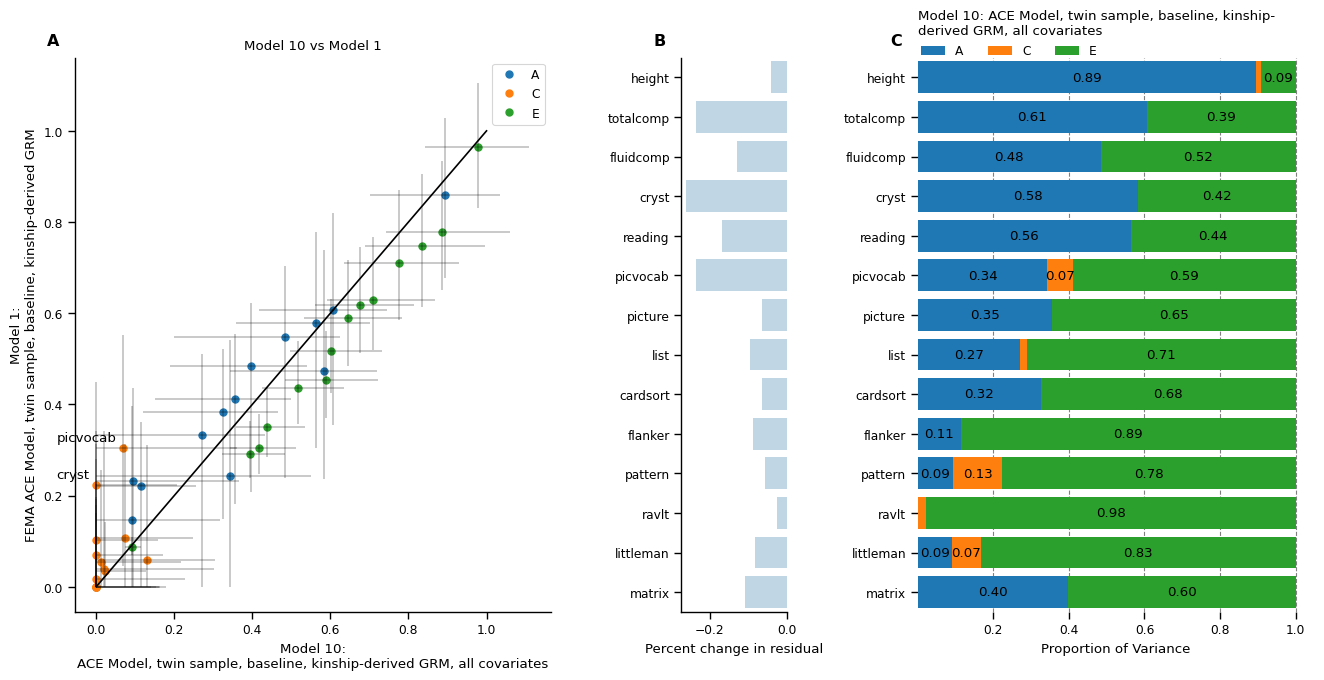

In [30]:
## MODEL 1

# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
# compare_models("s2_allcovs_m1", "model1", sig2mat, models, ax=ax0, lbl = [("totalcomp", "A"),("fluidcomp", "A"), 
#                                                                           ("picvocab", "C"),("flanker", "C"),
#                                                                           ("cryst", "C"),("matrix", "C"),
#                                                                           ("totalcomp", "E"),("flanker", "E"),
#                                                                           ("picvocab", "E")])

compare_models("s2_allcovs_m1", "model1", sig2mat, models, ax=ax0, lbl = .15)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("s2_allcovs_m1", "model1", model, models, baseline_phenos, sig2tvec = True, ax=ax1, debug=True)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s2_allcovs_m1", sig2mat, models, ax=ax2)
ax2.set_title('Model 10: ACE Model, twin sample, baseline, kinship-\nderived GRM, all covariates' + '\n', loc='left')

label_subplots([ax0,ax1,ax2])
plt.savefig(outpath + 'fig6.tiff', format='tiff', dpi = 300)

# Supplementary Figure 3. Model comparison using phenotypes residualized for additional covariates

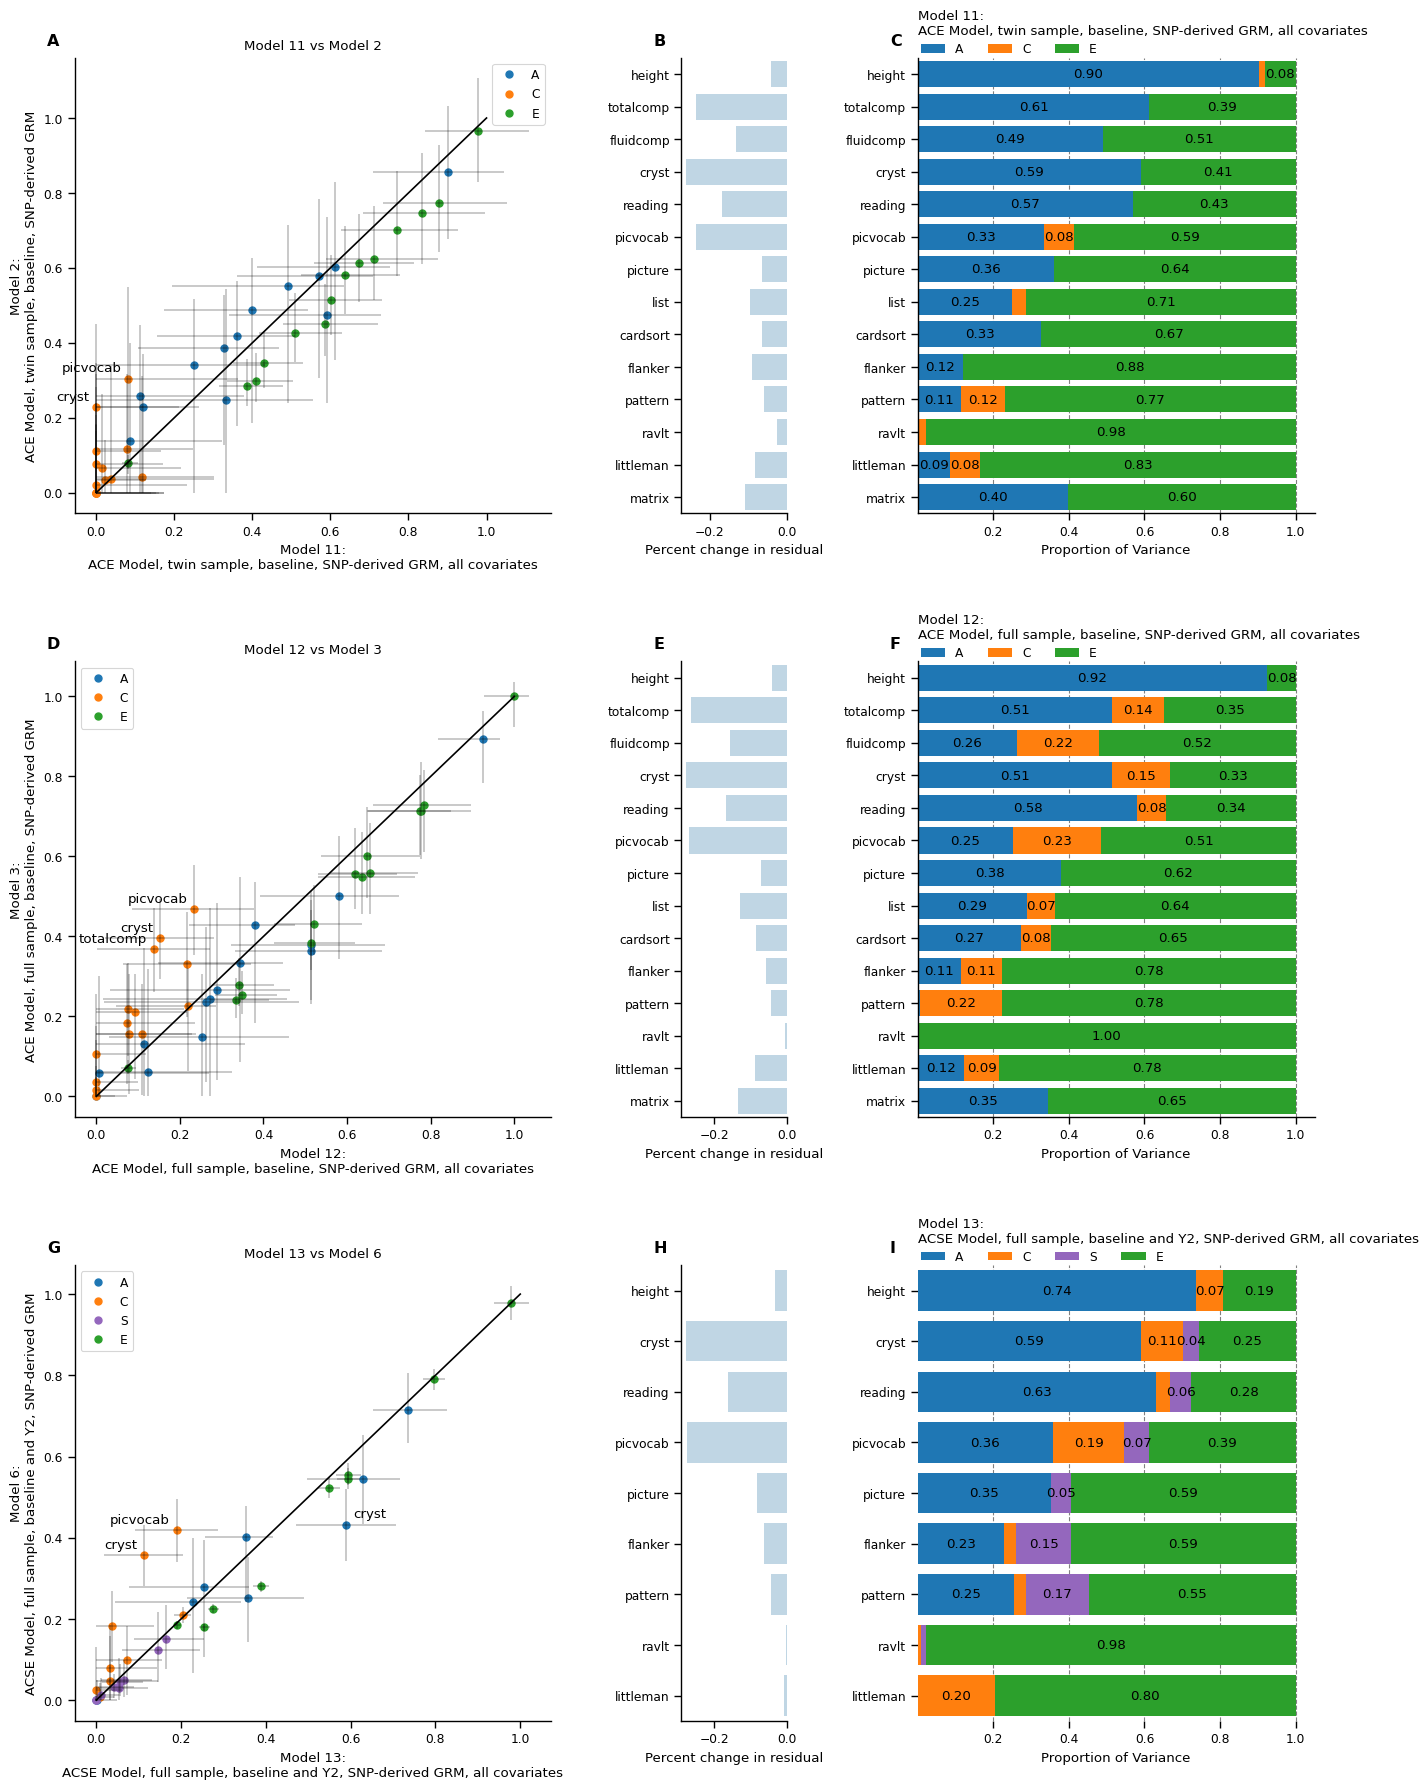

In [31]:
# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight*3))
# gs = GridSpec(nrows=4, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace*1.3)

gs = GridSpec(nrows=3, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace*1.3)

## MODEL 2

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("s2_allcovs_m2", "model2", sig2mat, models, ax=ax0, lbl = .15)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("s2_allcovs_m2", "model2", model, models, baseline_phenos, label=0.0001, sig2tvec = True, ax=ax1)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s2_allcovs_m2", sig2mat, models, ax=ax2)

## MODEL 3

# Left axes
ax3 = fig.add_subplot(gs[1, 0])
compare_models("s2_allcovs_m3", "model3", sig2mat, models, ax=ax3, lbl = .2)

# Middle axes
ax4=fig.add_subplot(gs[1,1])
plot_aic("s2_allcovs_m3", "model3", model, models, baseline_phenos, label=0.0001, sig2tvec = True, ax=ax4)

# Right axes
ax5=fig.add_subplot(gs[1, 2], sharey=ax4)
stacked_bar("s2_allcovs_m3", sig2mat, models, ax=ax5)

## MODEL 4

# Left axes
# ax6 = fig.add_subplot(gs[2, 0])
# compare_models("s2_allcovs_m4", "model4", sig2mat, models, ax=ax6, lbl = .38)

# # Middle axes
# ax7=fig.add_subplot(gs[2,1])
# plot_aic("s2_allcovs_m4", "model4", model, models, baseline_phenos, label=0.0001, sig2tvec = True, ax=ax7)

# # Right axes
# ax8=fig.add_subplot(gs[2, 2], sharey=ax7)
# stacked_bar("s2_allcovs_m4", sig2mat, models, ax=ax8)

## MODEL 5

# Left axes
ax9 = fig.add_subplot(gs[2, 0])
compare_models("s2_allcovs_m5", "model6", sig2mat, models, ax=ax9, lbl = .15)

# Middle axes
ax10=fig.add_subplot(gs[2,1])
plot_aic("s2_allcovs_m5", "model6", model, models, y2_phenos, label=0.0001, sig2tvec = True, ax=ax10)

# Right axes
ax11=fig.add_subplot(gs[2, 2], sharey=ax10)
stacked_bar("s2_allcovs_m5", sig2mat, models, ax=ax11)

# fig.tight_layout()

# label_subplots([ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11])
# plt.savefig(outpath + 'suppfig2.tiff', format='tiff', dpi = 300)

label_subplots([ax0,ax1,ax2,ax3,ax4,ax5,ax9,ax10,ax11])
plt.savefig(outpath + 'suppfig3.tiff', format='tiff', dpi = 300)

# Figure 7. ACSE model in longitudinal sample, in a sample that excludes twin registry participants

0    0.175526
1    0.008909
2    0.002412
3    0.021390
4    0.008404
5    0.019662
6    0.021995
7    0.023495
8    0.005307
Name: sig2tvec, dtype: float64
['littleman', 'ravlt', 'pattern', 'flanker', 'picture', 'picvocab', 'reading', 'cryst', 'height']



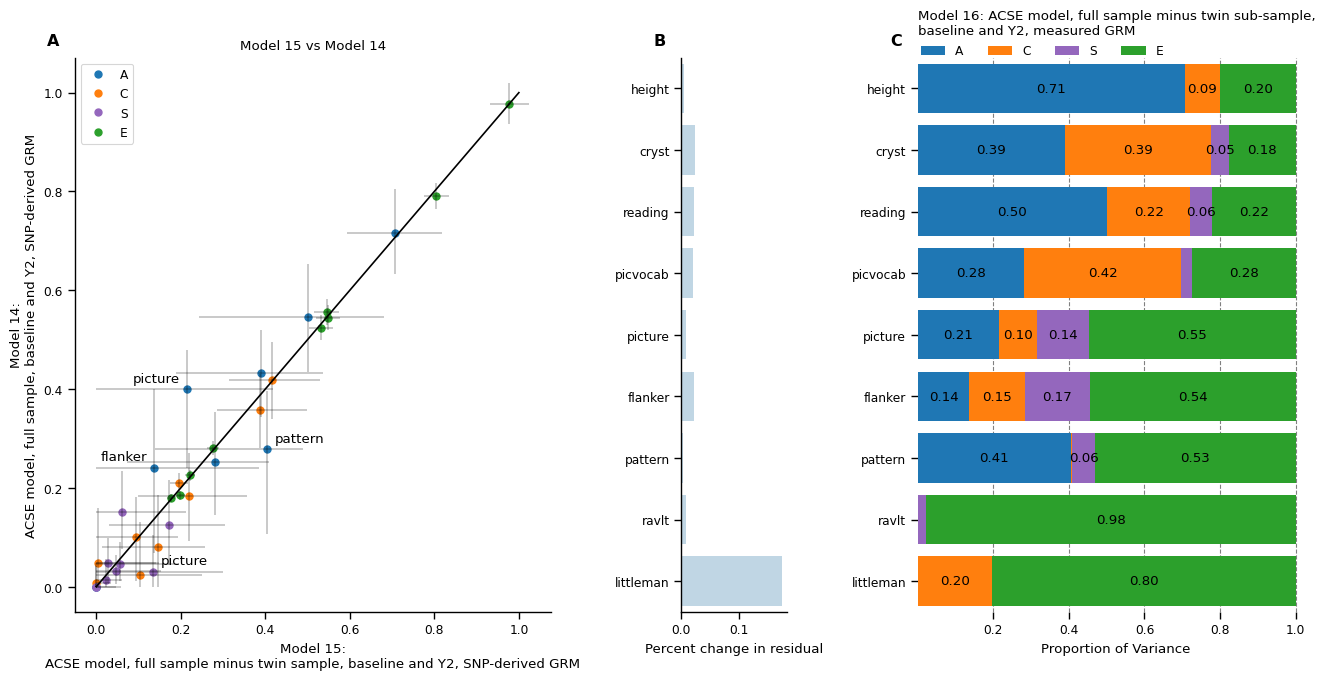

In [32]:
# compare_models("model5", "model4", sig2mat, models)

# stacked_bar("model5", sig2mat, models)

# Setting up the plot surface
fig = plt.figure(figsize=(figwidth, figheight))
gs = GridSpec(nrows=1, ncols=3, width_ratios = [9,2,7.5], wspace=wspace, hspace=hspace)

# Left axes
ax0 = fig.add_subplot(gs[0, 0])
compare_models("s3_notwins", "s3_notwins_comparison", sig2mat, models, ax=ax0, lbl = .1)

# Middle axes
ax1=fig.add_subplot(gs[0,1])
plot_aic("s3_notwins", "s3_notwins_comparison", model, models, y2_phenos, label=0, sig2tvec = True, ax=ax1, debug=True)

# Right axes
ax2=fig.add_subplot(gs[0, 2], sharey=ax1)
stacked_bar("s3_notwins", sig2mat, models, ax=ax2)
ax2.set_title('Model 16: ACSE model, full sample minus twin sub-sample, \nbaseline and Y2, measured GRM' + '\n', loc='left')

label_subplots([ax0,ax1,ax2])
plt.savefig(outpath + 'fig7.tiff', format='tiff', dpi = 300)

In [33]:
# printing heritability estimates
# [df[df['param']=='A'] for df in sig2mat]

for i in range(len(sig2mat)):
    print(models['shortname'][i])
    print(sig2mat[i][sig2mat[i]['param']=='A']['est'])



model1
0     0.483828
1     0.146049
2     0.000006
3     0.232458
4     0.221166
5     0.383039
6     0.333810
7     0.410948
8     0.242450
9     0.579373
10    0.474040
11    0.548254
12    0.606173
13    0.859007
Name: est, dtype: float64
model2
0     0.486494
1     0.136938
2     0.000006
3     0.258996
4     0.228004
5     0.385926
6     0.340003
7     0.418443
8     0.246481
9     0.577118
10    0.473637
11    0.551716
12    0.603266
13    0.856750
Name: est, dtype: float64
model3
0     0.333819
1     0.062247
2     0.000012
3     0.059176
4     0.130538
5     0.244305
6     0.267368
7     0.429088
8     0.148188
9     0.501637
10    0.364230
11    0.236729
12    0.379680
13    0.892908
Name: est, dtype: float64
model4
0     0.279012
1     0.062212
2     0.000008
3     0.059701
4     0.130588
5     0.244309
6     0.267301
7     0.428164
8     0.148136
9     0.470947
10    0.347259
11    0.236759
12    0.379687
13    0.881535
Name: est, dtype: float64
model5
0    3.346666e-10
1  

In [34]:
print(y2_phenos)

['littleman', 'ravlt', 'pattern', 'flanker', 'picture', 'picvocab', 'reading', 'cryst', 'height']


## Unused Code    

In [35]:
# old -- loading list of phenotypes (although this does automatically get the right order)

# baseline_phenofile = '/space/syn50/1/data/ABCD/d9smith/random_effects/behavioral/data/pheno/baseline_phenonames.txt'
# y2_phenofile = '/space/syn50/1/data/ABCD/d9smith/random_effects/behavioral/data/pheno/longitudinal_phenonames.txt'
# baseline_phenos = pd.read_csv(baseline_phenofile)
# y2_phenos = pd.read_csv(y2_phenofile)


In [36]:
# compare_models("model1", "openmx", sig2mat, models)
# fig = plt.figure()
# stacked_bar("model1", sig2mat, models)
# fig = plt.figure()
# plot_aic("model1", "openmx", model, models, baseline_phenos)


In [37]:
# # function to compile multipaneled figure
# def figure_panels(name1, name2, aic=False):
# #     """
# #     Compile multipaneled figure with model comparison, delta AIC plot (optional), and model estimates
    
# #     arguments:
# #     name1          :    string with title of model to plot on x axis
# #     name2          :    string with title of model to plot on y axis
# #     aic          :    bool indicating whether to plot aic difference
    
# #     """

In [38]:
# fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [1, 4]}, figsize=(7,6))

# # ax1.plot(x, y)
# # ax2.plot(x + 1, -y)

# # ax1=fig.add_subplot(0,0,0)
# plot_aic("model1", "openmx", model, models, baseline_phenos, ax=ax1)

# # Right axes
# # ax2=fig.add_subplot(0,0,1)
# stacked_bar("model1", sig2mat, models, ax=ax2)


# fig.tight_layout()

In [39]:
# # Setting up the plot surface
# fig = plt.figure(figsize=(10,10))
# gs = GridSpec(nrows=2, ncols=2, width_ratios = [2,8], height_ratios = [5,5])

# # Left axes
# ax0 = fig.add_subplot(gs[0, :])
# compare_models("model1", "openmx", sig2mat, models, ax=ax0, lbl = 0.05)

# # Middle axes
# ax1=fig.add_subplot(gs[1,0])
# plot_aic("model1", "openmx", model, models, baseline_phenos)

# # Right axes
# ax2=fig.add_subplot(gs[1, 1], sharey=ax1)
# stacked_bar("model1", sig2mat, models, ax=ax2)

# plt.tight_layout()
